#  imports

In [1]:
import pygeostat as gs
import gglib as gg
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, copy, shutil, sys, glob, time
from gglib.datamgmt.simpleio import *
%matplotlib inline

In [2]:
import spatialcluster as sp

In [3]:
variables = ['Ni', 'Fe', 'SiO2', 'MgO']
nsvariables = [f'NS_{v}' for v in variables]

In [4]:
plt.rcParams['axes.titlesize'] = 10

# functions

In [5]:
sys.path.insert(0, '../')
import validator.crossval as cv
import validator.validation_utils as vf
import validator.error_functions as ef
import validator.exporter as exp
exp.init_project('nilat_')

# parameters

In [6]:
masterseed = 201904
declus_cellsize = 50
saveplots = True
rng = np.random.RandomState(masterseed)
seeds = rng.permutation(2500)[:500]
ltrim = -999
searchparams = (50, 0, 0, 800, 600, 10)
nprocesses = 12
nreal = 100

workdir = 'L:/PhD-Wrapup/Nilat/sim/'
gs.ensure_path(workdir)

In [7]:
catvarmodels = gg.load_pickle('catvarmodels.pkl')
nsvarmodels = gg.load_pickle('nsvarmodels.pkl')

In [8]:
points = gg.PointContainer('nilat_maincats.dat')

griddef = gg.GridDef(open('griddef', 'r').read())
print(griddef)

92 1879.81 10.0 
99 8953.94 10.0 
23 896.36 2.0


# generate the k-folds

In [ ]:
nfolds = 5
ifolds = np.arange(nfolds, dtype=int) + 1

In [ ]:
points['origidx'] = points.data.index
points.writefile(points.flname)

In [ ]:
vf.spatialkfold(points, 'Ni', nfold=nfolds, outdir=workdir, rseed=masterseed+1)

K-Fold files generated in:
 L:/PhD-Wrapup/Nilat/sim/
Files:
 L:/PhD-Wrapup/Nilat/sim\Training01.dat
 L:/PhD-Wrapup/Nilat/sim\Training02.dat
 L:/PhD-Wrapup/Nilat/sim\Training03.dat
 L:/PhD-Wrapup/Nilat/sim\Training04.dat
 L:/PhD-Wrapup/Nilat/sim\Training05.dat
 L:/PhD-Wrapup/Nilat/sim\Validation01.dat
 L:/PhD-Wrapup/Nilat/sim\Validation02.dat
 L:/PhD-Wrapup/Nilat/sim\Validation03.dat
 L:/PhD-Wrapup/Nilat/sim\Validation04.dat
 L:/PhD-Wrapup/Nilat/sim\Validation05.dat


In [ ]:
foldfile = gg.PointContainer(workdir + 'spatialkfold.out')

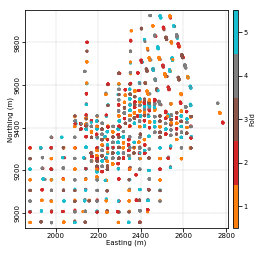

In [ ]:
qf = gg.QuickFormatter(fs=7)
ax = gs.locmap(foldfile, var=foldfile.columns[-1], 
               cmap='tab10', cbar_label='Fold', rotateticks=(0, 90), 
               figsize=(4, 4), s=4, rasterized=True)
qf(ax, tickrot=(0, 90))
exp.exportfigure('kfold_config.pdf')

# clipping boundaries

In [ ]:
boundct = vf.genkeyout_buffer(points, griddef, workdir, searchparams, 50)
boundct.info()
print('\nestimated locations: ', np.count_nonzero(boundct['key']))

GridContainer: L:/PhD-Wrapup/Nilat/sim/nilat_maincats_keyout.dat
No Special Attributes Found 

Grid Definitions:
92 1879.81 10.0 
99 8953.94 10.0 
23 896.36 2.0

Unused Columns:
['key']

estimated locations:  43537


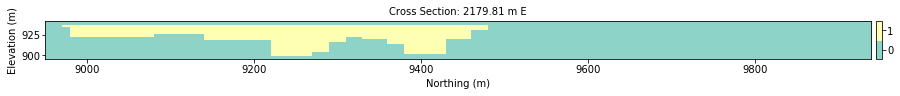

In [ ]:
ax = gs.pixelplt(boundct.data, griddef, pointdata=points, pointtol=0.1, sliceno=30, orient='yz', 
                 figsize=(15, 3))

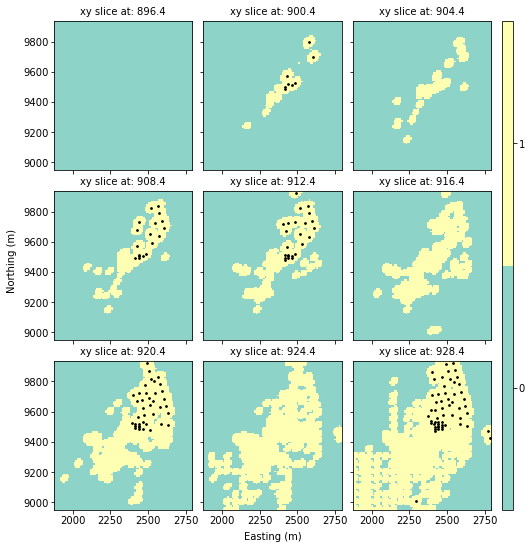

In [ ]:
fig = gs.gridslicer(boundct.data, griddef, nslice=9, 
                    pointdata=points, pointtol=0.1, point_kws={'s': 3}, 
                    figsize=(9, 9), orient='xy')

# GEOSTATS
    - decluster, despike, nstransform
    - variograms, cat and continuous
    - simulation, categorical and continuous
    - backtransform and post-processings
    - validation stuff

# single-cats

In [ ]:
t1 = time.time()
iseed = 0
catcols = ['modelcats', 'mvclus', 'betteragglom']
ifolditerator = [(ifold, catcol) for ifold in ifolds for catcol in catcols]
for iseed, (ifold, catcol) in gg.log_enum(ifolditerator):
    dtime = time.time()
    trainct = gg.PointContainer(f'{workdir}Training{ifold:02}.dat')
    testct = gg.PointContainer(f'{workdir}Validation{ifold:02}.dat')
    ### RUN CROSSVAL
    try:
        cv.domainfold(ifold, catcol, workdir, trainct, testct, boundct, griddef, variables, 
                          catvarmodels, nsvarmodels, declus_cellsize,
                          seeds[iseed], ltrim, nreal, searchparams, 
                          nprocesses, saveplots=False, trenddist=1000)
    except Exception as e:
        raise
    finally:
        pass
#         print(f'Finished fold {catcol} {ifold}\n'
#               f'  fold elapsed:  {(time.time()-dtime)/60:.4f} min\n'
#               f'  total elapsed: {(time.time()-t1)/60:.4f} min')
    plt.close()
    import gc; gc.collect()
print('Crossval finished in {:.4f} hours'.format((time.time() - t1) / 3600))

# multi-cats

In [ ]:
t1 = time.time()
iseed = 0
catbase_iterator = [
    ('reals_ensbest', [f'clusreal{i}' for i in range(nreal)]), 
   # ('reals_random', [f'randreal{i}' for i in range(nreal)])
]
for catbase, catcols in catbase_iterator:
    for ifold in ifolds:
        dtime = time.time()
        trainct = gg.PointContainer(f'{workdir}Training{ifold:02}.dat')
        testct = gg.PointContainer(f'{workdir}Validation{ifold:02}.dat')
        ### RUN CROSSVAL
        try:
            cv.domainfold_multi(
                ifold, catbase, catcols, workdir, trainct, testct, boundct, griddef, variables, 
                catvarmodels, nsvarmodels, declus_cellsize,
                seeds[iseed], ltrim, nreal, searchparams, 
                nprocesses, saveplots=False, trenddist=1000)
        except Exception as e:
            raise
        finally:
            pass
#         print(f'Finished fold {catbase} {ifold}\n'
#               f'  fold elapsed:  {(time.time()-dtime)/60:.4f} min\n'
#               f'  total elapsed: {(time.time()-t1)/60:.4f} min')
        iseed += 1
        plt.close()
        import gc; gc.collect()
print('Crossval finished in {:.4f} hours'.format((time.time() - t1) / 3600))